# CS2 Player Role Clustering Analysis

This notebook performs k-means clustering on player role features extracted from CS2 demo files to identify different player types and playstyles.

## Features Available:
- **Combat**: Kills, deaths, K/D ratio, headshot percentage
- **Timing**: Average time to kill, opening kills, time alive
- **Tactical**: Kills before/after bomb planting, bomb plants/defuses
- **Performance**: Multi-kills, damage dealt
- **Economic**: Weapon purchases (if available)


In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")


Libraries imported successfully!


## 1. Load and Explore Dat

In [84]:
# Load the player role features
df = pd.read_csv('player_role_features_combined.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst few rows:")
df.head()


Dataset shape: (80, 20)

Columns: ['player_name', 'demo_file', 'map_name', 'kills', 'deaths', 'kd_ratio', 'headshot_percentage', 'avg_time_to_kill_ticks', 'opening_kills', 'kills_before_bomb', 'kills_after_bomb', 'avg_time_alive_ticks', 'multi_kill_2k', 'multi_kill_3k', 'multi_kill_4k', 'multi_kill_5k', 'total_damage', 'damage_per_round', 'bombs_planted', 'bombs_defused']

First few rows:


,player_name,demo_file,map_name,kills,deaths,kd_ratio,headshot_percentage,avg_time_to_kill_ticks,opening_kills,kills_before_bomb,kills_after_bomb,avg_time_alive_ticks,multi_kill_2k,multi_kill_3k,multi_kill_4k,multi_kill_5k,total_damage,damage_per_round,bombs_planted,bombs_defused
0,a_m_c,aether-vs-full-send-m2-inferno,de_inferno,19,18,1.055556,26.315789,92657.842105,25,115,113,6948.80,4,2,0,0,2796,121.565217,1,0
1,sathsea,aether-vs-full-send-m2-inferno,de_inferno,20,18,1.111111,35.000000,96580.050000,25,114,126,8724.04,3,3,0,0,2463,107.086957,4,0
2,CULIACAN,aether-vs-full-send-m2-inferno,de_inferno,15,19,0.789474,53.333333,107290.733333,25,72,108,6167.64,5,0,0,0,2061,89.608696,0,0
3,micro,aether-vs-full-send-m2-inferno,de_inferno,20,13,1.538462,35.000000,104764.550000,25,95,145,10702.28,5,2,1,0,2871,124.826087,3,1
4,Majesticzz,aether-vs-full-send-m2-inferno,de_inferno,12,17,0.705882,50.000000,84216.250000,25,76,68,7499.64,2,0,0,0,1875,81.521739,0,0


In [85]:
# Basic data exploration
print("Dataset Info:")
print(f"Total players: {len(df)}")
print(f"Unique maps: {df['map_name'].nunique()}")
print(f"Maps: {df['map_name'].unique()}")
print(f"\nBasic statistics:")
df.describe()


Dataset Info:
Total players: 80
Unique maps: 4
Maps: ['de_inferno' 'de_mirage' 'de_train' 'de_nuke']

Basic statistics:


,kills,deaths,kd_ratio,headshot_percentage,avg_time_to_kill_ticks,opening_kills,kills_before_bomb,kills_after_bomb,avg_time_alive_ticks,multi_kill_2k,multi_kill_3k,multi_kill_4k,multi_kill_5k,total_damage,damage_per_round,bombs_planted,bombs_defused
count,80.000000,80.00000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.00000,80.000000,80.000000,80.000000,80.00000
mean,15.387500,15.52500,1.061762,50.088774,80257.845014,22.125000,77.725000,73.750000,9514.463363,3.737500,1.112500,0.162500,0.02500,2177.000000,98.818508,0.950000,0.23750
std,5.183942,3.76518,0.465188,17.082611,25962.088565,4.535025,44.783297,41.900273,6400.129572,1.992033,1.090741,0.403897,0.15711,669.469864,25.536437,0.966528,0.45684
min,4.000000,6.00000,0.307692,21.052632,32332.000000,12.000000,12.000000,4.000000,4703.812500,0.000000,0.000000,0.000000,0.00000,662.000000,38.941176,0.000000,0.00000
25%,12.000000,14.00000,0.666667,35.000000,60487.546875,17.000000,47.750000,46.750000,6683.404231,2.000000,0.000000,0.000000,0.00000,1687.250000,82.360435,0.000000,0.00000
50%,15.000000,16.00000,1.000000,48.809524,75119.943636,25.000000,70.500000,71.500000,7579.555556,4.000000,1.000000,0.000000,0.00000,2230.000000,96.405797,1.000000,0.00000
75%,19.000000,18.00000,1.313322,62.500000,93096.327731,26.000000,97.250000,92.250000,9432.042929,5.000000,2.000000,0.000000,0.00000,2615.500000,117.618207,1.000000,0.00000
max,29.000000,22.00000,2.250000,93.750000,144518.181818,27.000000,239.000000,215.000000,45709.636364,10.000000,4.000000,2.000000,1.00000,3779.000000,151.160000,4.000000,2.00000


In [86]:
# Check for missing values
print("Missing values:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

# Fill missing values with 0 for numerical features
df = df.fillna(0)
print("\nMissing values after filling:", df.isnull().sum().sum())


Missing values:
Series([], dtype: int64)

Missing values after filling: 0


## 2. Data Preprocessing and Feature Selection


In [87]:
# Aggregate the dataframe by player_name, ignoring map_name and demo_file
# We'll aggregate most features by sum, but headshot_percentage by mean
# Remove 'map_name' and 'demo_file' from the dataframe for aggregation

agg_columns = [col for col in df.columns if col not in ['map_name', 'demo_file', 'player_name']]

# Define aggregation methods - most features should be summed, but percentages should be averaged
agg_dict = {}
for col in agg_columns:
    if col == 'headshot_percentage':
        agg_dict[col] = 'mean'  # Average headshot percentage across matches
    else:
        agg_dict[col] = 'sum'   # Sum all other features

df_agg = df.groupby('player_name').agg(agg_dict).reset_index()

print(f"Aggregated dataframe shape: {df_agg.shape}")
print("Sample of aggregated dataframe:")
print(df_agg.head())

# Use the aggregated dataframe for further analysis
df = df_agg

# Select numerical features for clustering
# Exclude identifier columns and keep meaningful features
feature_columns = [
    'kills', 'deaths', 'kd_ratio', 'headshot_percentage',
    'avg_time_to_kill_ticks', 'opening_kills', 
    'kills_before_bomb', 'kills_after_bomb', 'avg_time_alive_ticks',
    'multi_kill_2k', 'multi_kill_3k', 'multi_kill_4k', 'multi_kill_5k',
    'total_damage', 'damage_per_round', 'bombs_planted', 'bombs_defused'
]

# Create feature matrix from aggregated dataframe
X = df[feature_columns].copy()

print(f"Feature matrix shape: {X.shape}")
print(f"Features used: {feature_columns}")

# Display feature statistics
X.describe()



Aggregated dataframe shape: (30, 18)
Sample of aggregated dataframe:
  player_name  kills  deaths  kd_ratio  headshot_percentage  \
0    ---Beast     55      45  3.802696            57.619048   
1       1TyRa     54      44  3.706061            50.710109   
2     4TAYLOR     48      58  2.471053            55.860806   
3      ADDICT     31      18  3.444444            67.543860   
4    CULIACAN     45      56  2.421827            51.111111   

   avg_time_to_kill_ticks  opening_kills  kills_before_bomb  kills_after_bomb  \
0           289213.050000             73                315               327   
1           301732.860902             71                332               337   
2           276773.355311             78                200               232   
3            98526.842105             33                 91                81   
4           283104.266667             75                183               237   

   avg_time_alive_ticks  multi_kill_2k  multi_kill_3k  multi_kill

,kills,deaths,kd_ratio,headshot_percentage,avg_time_to_kill_ticks,opening_kills,kills_before_bomb,kills_after_bomb,avg_time_alive_ticks,multi_kill_2k,multi_kill_3k,multi_kill_4k,multi_kill_5k,total_damage,damage_per_round,bombs_planted,bombs_defused
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,41.033333,41.400000,2.831366,51.208145,214020.920037,59.000000,207.266667,196.666667,25371.902302,9.966667,2.966667,0.433333,0.066667,5805.333333,263.516022,2.533333,0.633333
std,15.597266,14.526076,1.021216,11.089102,76437.320193,20.468647,112.121527,101.133348,11173.077851,4.701308,2.042367,0.727932,0.253708,2157.567010,75.977579,1.851995,0.614948
min,9.000000,15.000000,0.692308,31.216931,89104.400000,25.000000,33.000000,23.000000,9475.283088,1.000000,0.000000,0.000000,0.000000,1410.000000,80.496732,0.000000,0.000000
25%,31.000000,28.750000,2.251031,44.507101,122919.727431,33.000000,89.500000,93.750000,20139.989758,6.250000,2.000000,0.000000,0.000000,4001.000000,225.701561,1.000000,0.000000
50%,45.000000,47.500000,3.010345,50.910610,244672.782195,70.000000,247.500000,218.000000,23433.717511,9.500000,3.000000,0.000000,0.000000,6422.500000,279.121775,2.000000,1.000000
75%,53.250000,53.000000,3.625000,57.589286,274091.508103,74.750000,297.250000,287.750000,27565.120797,14.000000,4.000000,1.000000,0.000000,7385.750000,318.774565,3.750000,1.000000
max,68.000000,58.000000,4.291751,68.750000,314587.747024,78.000000,382.000000,337.000000,61780.903030,19.000000,8.000000,3.000000,1.000000,9467.000000,393.361087,7.000000,2.000000


In [88]:
# Scale features for k-means clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Scaled feature matrix shape: {X_scaled.shape}")
print(f"\nScaled features mean: {X_scaled.mean(axis=0).round(3)}")
print(f"Scaled features std: {X_scaled.std(axis=0).round(3)}")


Scaled feature matrix shape: (30, 17)

Scaled features mean: [ 0.  0.  0. -0.  0. -0. -0.  0. -0. -0. -0. -0. -0.  0. -0.  0.  0.]
Scaled features std: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


## 3. Determine Optimal Number of Clusters


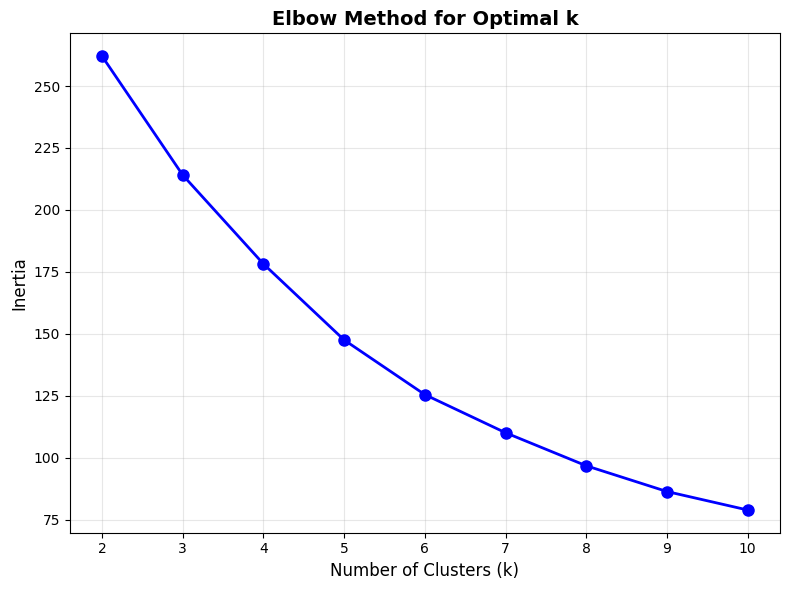

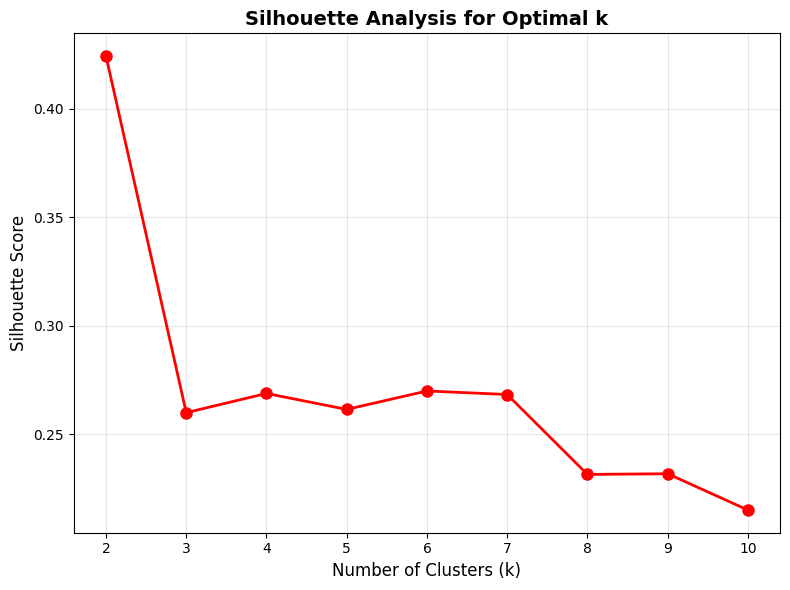


Silhouette Scores:
k=2: 0.424
k=3: 0.260
k=4: 0.269
k=5: 0.261
k=6: 0.270
k=7: 0.268
k=8: 0.231
k=9: 0.232
k=10: 0.215

Optimal k based on silhouette score: 2


In [89]:
# Elbow method and silhouette analysis
k_range = range(2, 11)
inertias = []
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot Elbow Method separately
plt.figure(figsize=(8, 6))
plt.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.title('Elbow Method for Optimal k', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(k_range)
plt.tight_layout()
plt.show()

# Plot Silhouette Analysis separately
plt.figure(figsize=(8, 6))
plt.plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Silhouette Analysis for Optimal k', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(k_range)
plt.tight_layout()
plt.show()

print("\nSilhouette Scores:")
for k, score in zip(k_range, silhouette_scores):
    print(f"k={k}: {score:.3f}")

# Find optimal k
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\nOptimal k based on silhouette score: {optimal_k}")


## 4. Perform K-Means Clustering


In [90]:
# Perform k-means clustering with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to original dataframe
df['cluster'] = cluster_labels

print(f"Clustering completed with k={optimal_k}")
print(f"Silhouette score: {silhouette_score(X_scaled, cluster_labels):.3f}")

# Cluster distribution
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
print(f"\nCluster distribution:")
for cluster, count in cluster_counts.items():
    print(f"Cluster {cluster}: {count} players ({count/len(df)*100:.1f}%)")


Clustering completed with k=2
Silhouette score: 0.424

Cluster distribution:
Cluster 0: 20 players (66.7%)
Cluster 1: 10 players (33.3%)


In [ ]:
# Create PCA Scree Plot
plt.figure(figsize=(10, 6))
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot individual explained variance
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, 
         'bo-', linewidth=2, markersize=8, label='Individual Variance')
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance, 
         'ro-', linewidth=2, markersize=8, label='Cumulative Variance')

plt.xlabel('Principal Component', fontsize=12)
plt.ylabel('Explained Variance Ratio', fontsize=12)
plt.title('PCA Scree Plot - Player Role Features', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(range(1, len(explained_variance_ratio) + 1))

# Add percentage labels for first few components
for i, (var, cum_var) in enumerate(zip(explained_variance_ratio[:5], cumulative_variance[:5])):
    plt.text(i+1, var + 0.01, f'{var:.1%}', ha='center', va='bottom', fontsize=9)
    if i == 1:  # Highlight PC2
        plt.text(i+1, cum_var + 0.03, f'{cum_var:.1%}', ha='center', va='bottom', 
                fontsize=9, fontweight='bold', color='red')

plt.tight_layout()
plt.show()

print("PCA Scree Plot Analysis:")
print(f"PC1 explains {explained_variance_ratio[0]:.1%} of variance")
print(f"PC2 explains {explained_variance_ratio[1]:.1%} of variance")
print(f"First 2 components capture {cumulative_variance[1]:.1%} of total variance")


In [ ]:
# Create PCA Loading Plot
plt.figure(figsize=(12, 8))

# Get loadings for first two components
loadings = pca.components_[:2].T

# Create loading plot
plt.scatter(loadings[:, 0], loadings[:, 1], alpha=0.7, s=100, c='blue', edgecolors='black')

# Add feature labels
feature_labels = ['Kills', 'Deaths', 'K/D', 'HS%', 'TTK', 'Opening', 
                 'K-Before', 'K-After', 'Time-Alive', '2K', '3K', '4K', '5K',
                 'Damage', 'Dmg/Rnd', 'Plants', 'Defuses']

for i, feature in enumerate(feature_labels):
    plt.annotate(feature, (loadings[i, 0], loadings[i, 1]), 
                xytext=(5, 5), textcoords='offset points', fontsize=9)

plt.xlabel(f'PC1 Loadings ({explained_variance_ratio[0]:.1%} variance)', fontsize=12, fontweight='bold')
plt.ylabel(f'PC2 Loadings ({explained_variance_ratio[1]:.1%} variance)', fontsize=12, fontweight='bold')
plt.title('PCA Loading Plot - Feature Relationships', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)

# Add interpretation text
plt.text(0.02, 0.98, 'PC1: Overall Player Activity Level', transform=plt.gca().transAxes, 
         fontsize=10, verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))
plt.text(0.02, 0.90, 'PC2: Tactical Positioning Style', transform=plt.gca().transAxes, 
         fontsize=10, verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen"))

plt.tight_layout()
plt.show()

print("PCA Loading Plot Analysis:")
print("Features close together have similar relationships to the principal components")
print("PC1 (horizontal): Positive values = high activity, Negative values = low activity")
print("PC2 (vertical): Positive values = supportive play, Negative values = aggressive play")


In [91]:
# PCA for 2D visualization (needed for later comparisons)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Create PCA dataframe
pca_df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'cluster': cluster_labels,
    'player_name': df['player_name']
})

print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {pca.explained_variance_ratio_.sum():.3f}")


PCA explained variance ratio: [0.57961878 0.12318576]
Total explained variance: 0.703


## 4.5. Hierarchical Clustering with Cosine Similarity


Cosine similarity matrix shape: (30, 30)


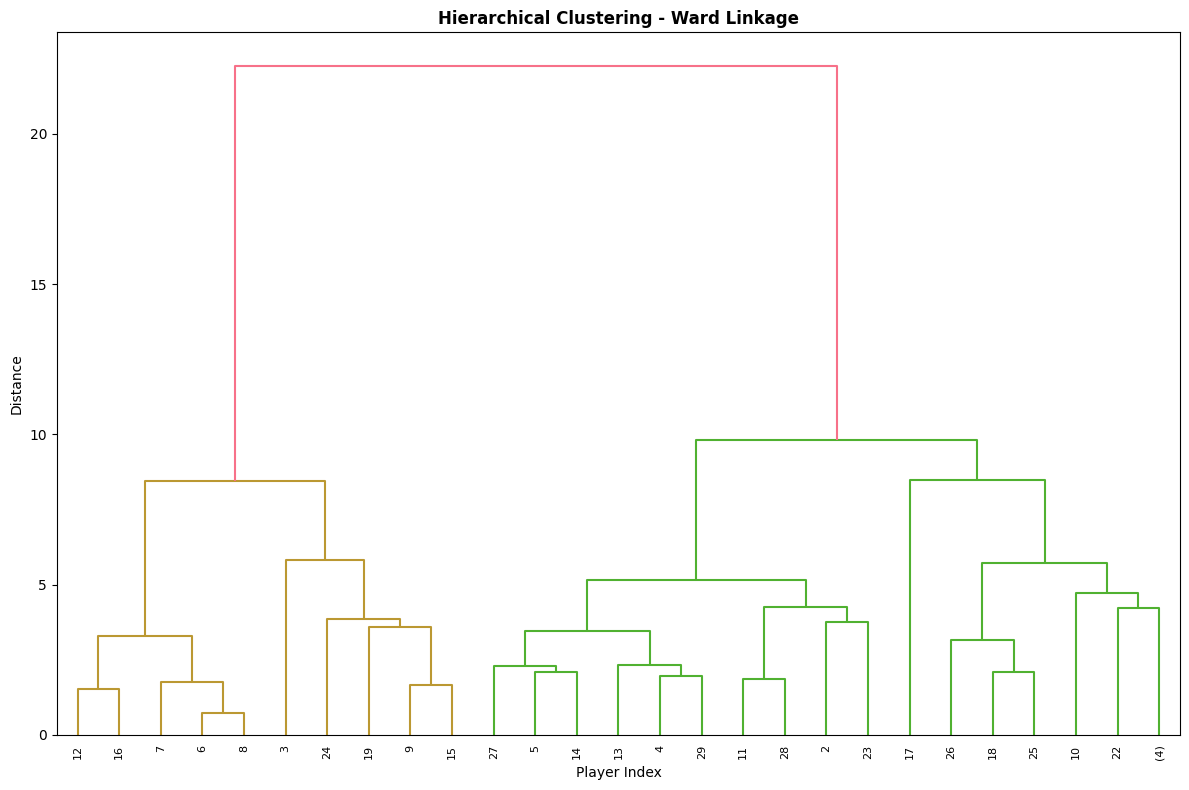


Hierarchical clustering completed with k=2
Hierarchical clustering silhouette score: 0.424
Adjusted Rand Index (k-means vs hierarchical): 1.000
(1.0 = perfect agreement, 0.0 = random agreement)

Hierarchical cluster distribution:
Cluster 0: 20 players (66.7%)
Cluster 1: 10 players (33.3%)


In [106]:
# Hierarchical clustering with cosine similarity
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform

# Calculate cosine similarity matrix
cosine_sim_matrix = cosine_similarity(X_scaled)
print(f"Cosine similarity matrix shape: {cosine_sim_matrix.shape}")

# Convert to distance matrix (1 - similarity)
cosine_distances = 1 - cosine_sim_matrix
# Ensure diagonal is exactly zero for valid distance matrix
np.fill_diagonal(cosine_distances, 0)
cosine_distances = squareform(cosine_distances)

# Perform hierarchical clustering using different linkage methods
linkage_methods = ['ward']

# Only plot the ward linkage method
fig, ax = plt.subplots(figsize=(12, 8))
axes = [ax]

for i, method in enumerate(linkage_methods):
    # Perform linkage
    if method == 'ward':
        # Ward linkage works with Euclidean distance, so we use the original scaled data
        linkage_matrix = linkage(X_scaled, method=method)
    else:
        # Other methods can work with precomputed distances
        linkage_matrix = linkage(cosine_distances, method=method)
    
    # Plot dendrogram
    dendrogram(linkage_matrix, 
               truncate_mode='level', 
               p=5,  # Show only the last 5 merged clusters
               ax=axes[i],
               leaf_rotation=90,
               leaf_font_size=8)
    axes[i].set_title(f'Hierarchical Clustering - {method.title()} Linkage', fontweight='bold')
    axes[i].set_xlabel('Player Index')
    axes[i].set_ylabel('Distance')

plt.tight_layout()
plt.show()

# Use Ward linkage for final hierarchical clustering (most common choice)
linkage_matrix = linkage(X_scaled, method='ward')

# Perform hierarchical clustering with optimal k
hierarchical_clustering = AgglomerativeClustering(
    n_clusters=optimal_k, 
    linkage='ward'
)
hier_labels = hierarchical_clustering.fit_predict(X_scaled)

print(f"\nHierarchical clustering completed with k={optimal_k}")
print(f"Hierarchical clustering silhouette score: {silhouette_score(X_scaled, hier_labels):.3f}")

# Compare k-means and hierarchical clustering results
from sklearn.metrics import adjusted_rand_score

ari_score = adjusted_rand_score(cluster_labels, hier_labels)
print(f"Adjusted Rand Index (k-means vs hierarchical): {ari_score:.3f}")
print("(1.0 = perfect agreement, 0.0 = random agreement)")

# Show cluster distribution for hierarchical clustering
hier_cluster_counts = pd.Series(hier_labels).value_counts().sort_index()
print(f"\nHierarchical cluster distribution:")
for cluster, count in hier_cluster_counts.items():
    print(f"Cluster {cluster}: {count} players ({count/len(df)*100:.1f}%)")


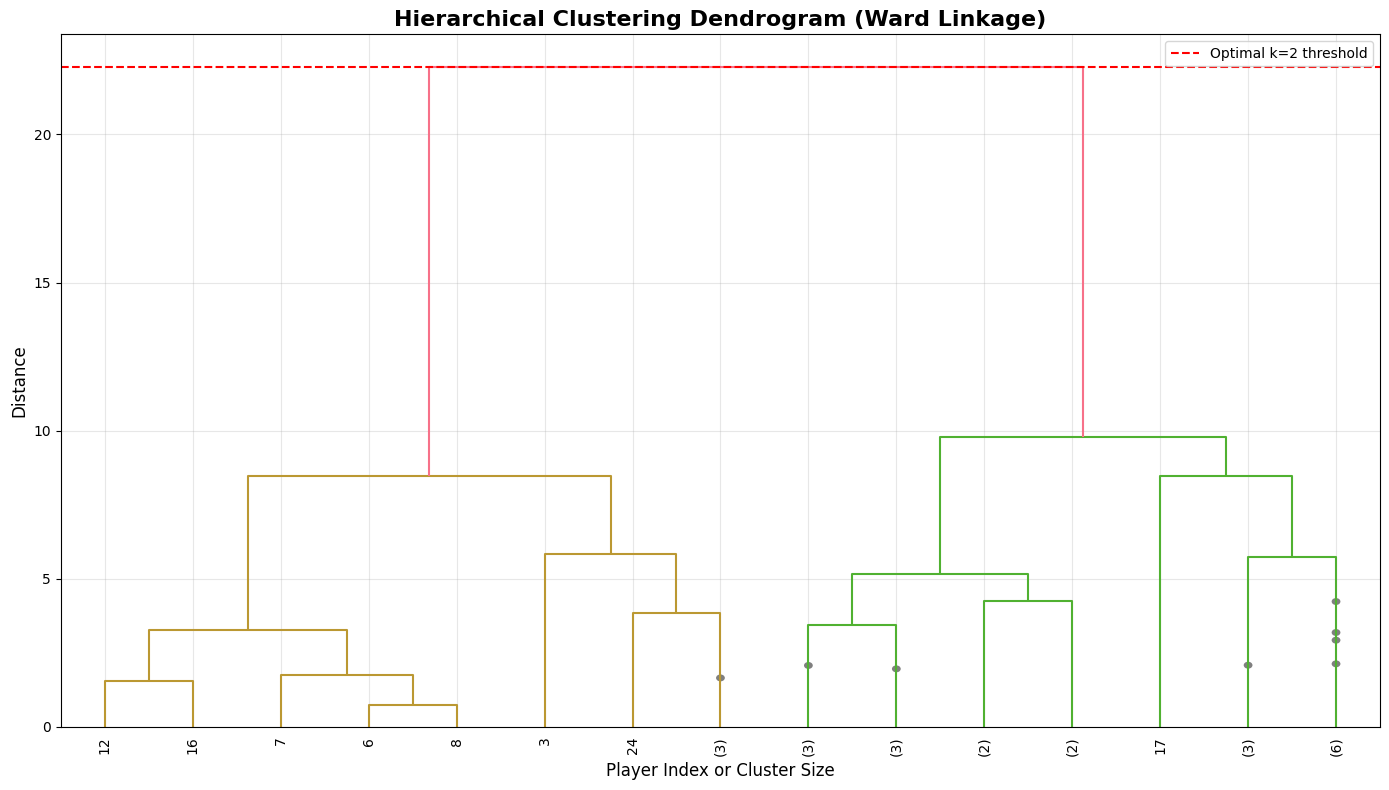

Dendrogram Analysis:
Number of linkage levels: 29
Maximum distance: 22.27
Minimum distance: 0.73

Linkage matrix shape: (29, 4)
First few linkage steps:
Step 1: Merge clusters 6 and 8 at distance 0.73 (new cluster size: 2)
Step 2: Merge clusters 12 and 16 at distance 1.54 (new cluster size: 2)
Step 3: Merge clusters 9 and 15 at distance 1.66 (new cluster size: 2)
Step 4: Merge clusters 7 and 30 at distance 1.77 (new cluster size: 3)
Step 5: Merge clusters 11 and 28 at distance 1.85 (new cluster size: 2)


In [93]:
# Create a detailed dendrogram for the main analysis
plt.figure(figsize=(14, 8))

# Use Ward linkage for the main dendrogram
linkage_matrix = linkage(X_scaled, method='ward')

# Create the dendrogram
dendrogram(linkage_matrix,
           truncate_mode='level',
           p=3,  # Show last 3 levels
           leaf_rotation=90,
           leaf_font_size=10,
           show_contracted=True)

plt.title('Hierarchical Clustering Dendrogram (Ward Linkage)', 
          fontsize=16, fontweight='bold')
plt.xlabel('Player Index or Cluster Size', fontsize=12)
plt.ylabel('Distance', fontsize=12)
plt.grid(True, alpha=0.3)

# Add horizontal line at optimal k
if optimal_k > 1:
    # Calculate the distance threshold for optimal k clusters
    distances = linkage_matrix[:, 2]
    sorted_distances = sorted(distances, reverse=True)
    threshold = sorted_distances[optimal_k - 2] if optimal_k > 1 else max(distances)
    plt.axhline(y=threshold, color='red', linestyle='--', 
                label=f'Optimal k={optimal_k} threshold')
    plt.legend()

plt.tight_layout()
plt.show()

# Analyze the dendrogram structure
print("Dendrogram Analysis:")
print(f"Number of linkage levels: {len(linkage_matrix)}")
print(f"Maximum distance: {linkage_matrix[:, 2].max():.2f}")
print(f"Minimum distance: {linkage_matrix[:, 2].min():.2f}")

# Show the linkage matrix structure
print(f"\nLinkage matrix shape: {linkage_matrix.shape}")
print("First few linkage steps:")
for i, (left, right, distance, count) in enumerate(linkage_matrix[:5]):
    print(f"Step {i+1}: Merge clusters {int(left)} and {int(right)} at distance {distance:.2f} (new cluster size: {int(count)})")


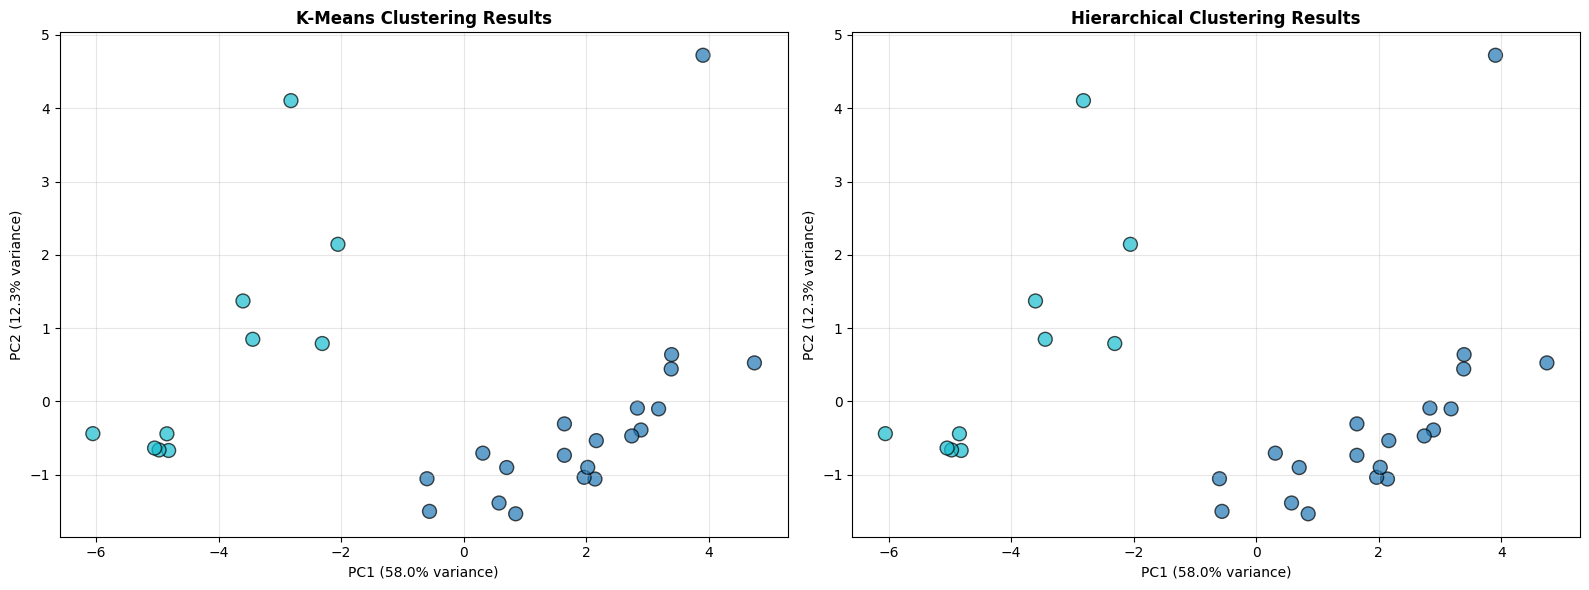


Clustering Method Comparison:
         Method  Silhouette Score  Cluster 0 Size  Cluster 1 Size  ARI Score
0       K-Means             0.424              20              10        1.0
1  Hierarchical             0.424              20              10        1.0

Cluster Agreement Analysis:
Players with same cluster assignment: 30/30 (100.0%)
Adjusted Rand Index: 1.000

Both methods produce identical cluster assignments!


In [109]:
# Update PCA dataframe with hierarchical clustering labels
pca_df['hier_cluster'] = hier_labels

# Compare k-means and hierarchical clustering results
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# K-means clustering visualization
scatter1 = axes[0].scatter(pca_df['PC1'], pca_df['PC2'], c=cluster_labels, 
                          cmap='tab10', alpha=0.7, s=100, edgecolors='black')
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
axes[0].set_title('K-Means Clustering Results', fontweight='bold')
axes[0].grid(True, alpha=0.3)
# Hierarchical clustering visualization
scatter2 = axes[1].scatter(pca_df['PC1'], pca_df['PC2'], c=hier_labels, 
                          cmap='tab10', alpha=0.7, s=100, edgecolors='black')
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
axes[1].set_title('Hierarchical Clustering Results', fontweight='bold')
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Create a comparison table
comparison_data = {
    'Method': ['K-Means', 'Hierarchical'],
    'Silhouette Score': [silhouette_score(X_scaled, cluster_labels), 
                        silhouette_score(X_scaled, hier_labels)],
    'Cluster 0 Size': [cluster_counts.get(0, 0), hier_cluster_counts.get(0, 0)],
    'Cluster 1 Size': [cluster_counts.get(1, 0), hier_cluster_counts.get(1, 0)],
    'ARI Score': [1.0, ari_score]  # K-means vs itself = 1.0
}

comparison_df = pd.DataFrame(comparison_data)
print("\nClustering Method Comparison:")
print(comparison_df.round(3))

# Analyze cluster agreement
agreement = (cluster_labels == hier_labels).sum()
total_players = len(cluster_labels)
agreement_pct = (agreement / total_players) * 100

print(f"\nCluster Agreement Analysis:")
print(f"Players with same cluster assignment: {agreement}/{total_players} ({agreement_pct:.1f}%)")
print(f"Adjusted Rand Index: {ari_score:.3f}")

# Show players where methods disagree
disagreement_mask = cluster_labels != hier_labels
if disagreement_mask.any():
    print(f"\nPlayers where methods disagree:")
    disagree_df = df[disagreement_mask][['player_name', 'kd_ratio', 'headshot_percentage', 
                                       'opening_kills', 'damage_per_round']].copy()
    disagree_df['kmeans_cluster'] = cluster_labels[disagreement_mask]
    disagree_df['hier_cluster'] = hier_labels[disagreement_mask]
    print(disagree_df)
else:
    print("\nBoth methods produce identical cluster assignments!")


## 5. Analyze Cluster Characteristics


In [95]:
# Calculate cluster centroids and analyze characteristics
cluster_centroids = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),
    columns=feature_columns
)
cluster_centroids.index = [f'Cluster {i}' for i in range(optimal_k)]

print("Cluster Centroids (Original Scale):")
print(cluster_centroids.round(2))


Cluster Centroids (Original Scale):
           kills  deaths  kd_ratio  headshot_percentage  \
Cluster 0   50.2   50.75      3.08                46.73   
Cluster 1   22.7   22.70      2.33                60.16   

           avg_time_to_kill_ticks  opening_kills  kills_before_bomb  \
Cluster 0               264616.29          72.95             278.25   
Cluster 1               112830.17          31.10              65.30   

           kills_after_bomb  avg_time_alive_ticks  multi_kill_2k  \
Cluster 0            258.85              28308.68           12.0   
Cluster 1             72.30              19498.36            5.9   

           multi_kill_3k  multi_kill_4k  multi_kill_5k  total_damage  \
Cluster 0            3.9           0.55           0.05        7123.7   
Cluster 1            1.1           0.20           0.10        3168.6   

           damage_per_round  bombs_planted  bombs_defused  
Cluster 0            304.80            3.2           0.75  
Cluster 1            180.96   

In [96]:
# Analyze key features by cluster
key_features = ['kills', 'deaths', 'kd_ratio', 'headshot_percentage', 
                'opening_kills', 'kills_before_bomb', 'kills_after_bomb',
                'avg_time_alive_ticks', 'multi_kill_2k', 'damage_per_round']

cluster_analysis = df.groupby('cluster')[key_features].mean().round(2)
print("Key Features by Cluster:")
print(cluster_analysis)


Key Features by Cluster:
         kills  deaths  kd_ratio  headshot_percentage  opening_kills  \
cluster                                                                
0         50.2   50.75      3.08                46.73          72.95   
1         22.7   22.70      2.33                60.16          31.10   

         kills_before_bomb  kills_after_bomb  avg_time_alive_ticks  \
cluster                                                              
0                   278.25            258.85              28308.68   
1                    65.30             72.30              19498.36   

         multi_kill_2k  damage_per_round  
cluster                                   
0                 12.0            304.80  
1                  5.9            180.96  


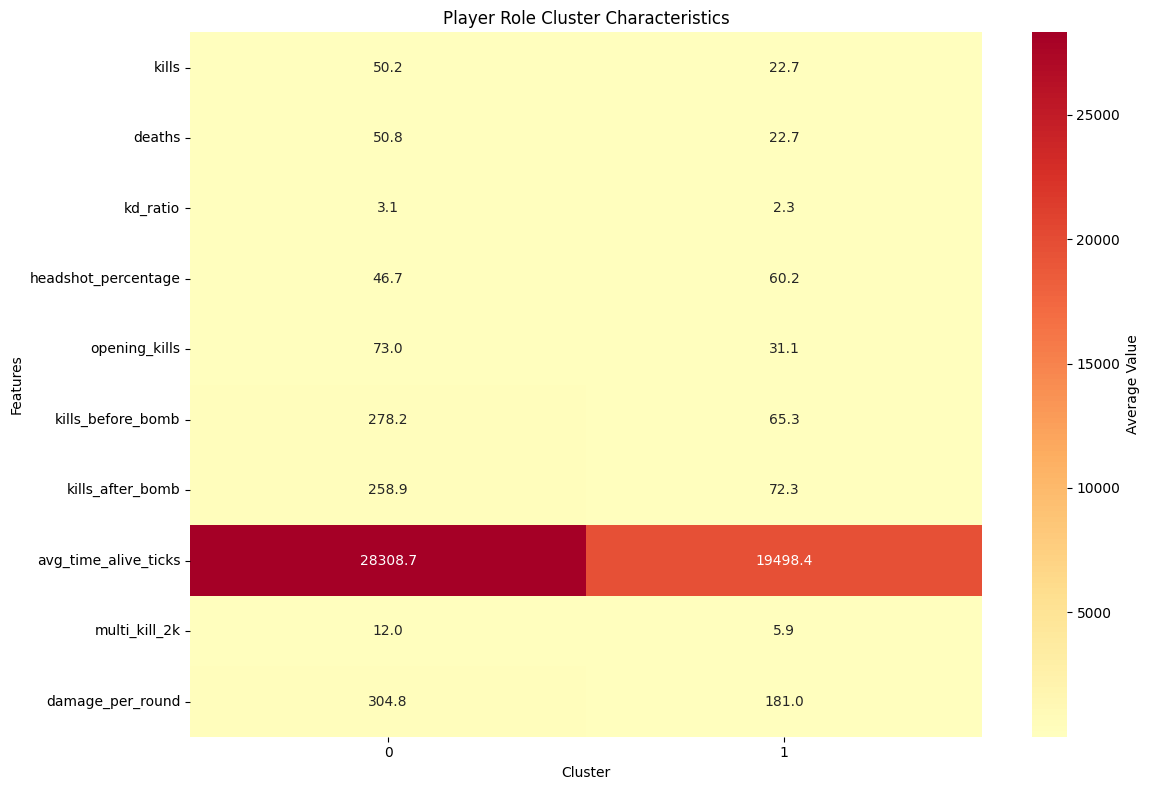

In [97]:
# Create a heatmap of cluster characteristics
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_analysis.T, annot=True, cmap='RdYlBu_r', center=0, 
            fmt='.1f', cbar_kws={'label': 'Average Value'})
plt.title('Player Role Cluster Characteristics')
plt.xlabel('Cluster')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


## 6. Visualize Clusters


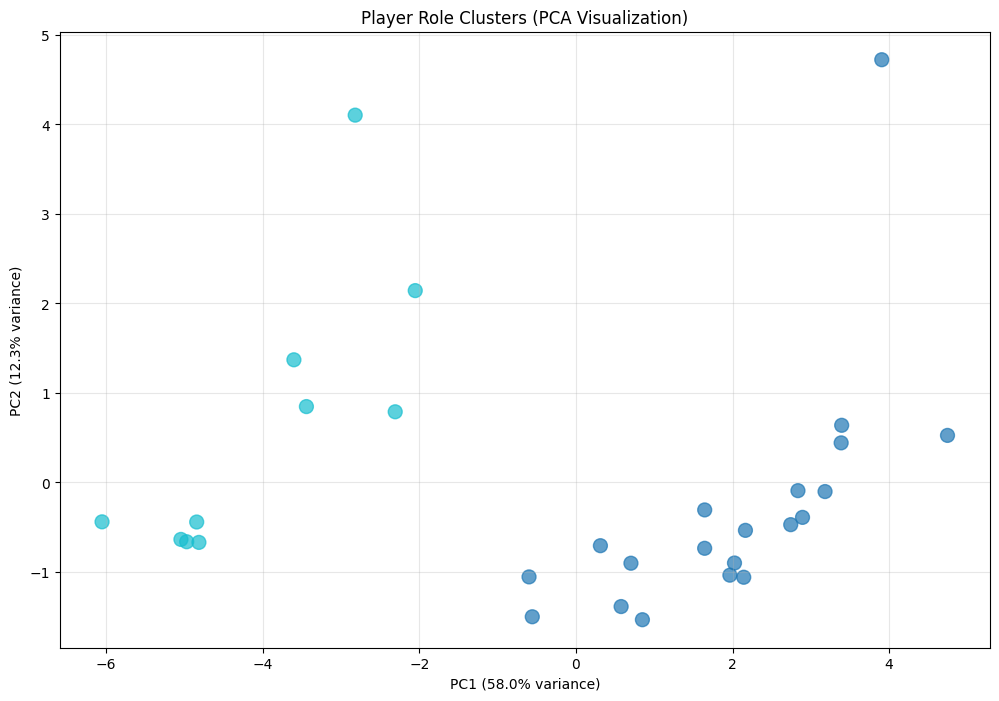

In [107]:
# Plot clusters in 2D
plt.figure(figsize=(12, 8))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['cluster'], 
                     cmap='tab10', alpha=0.7, s=100)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.title('Player Role Clusters (PCA Visualization)')
plt.grid(True, alpha=0.3)
plt.show()


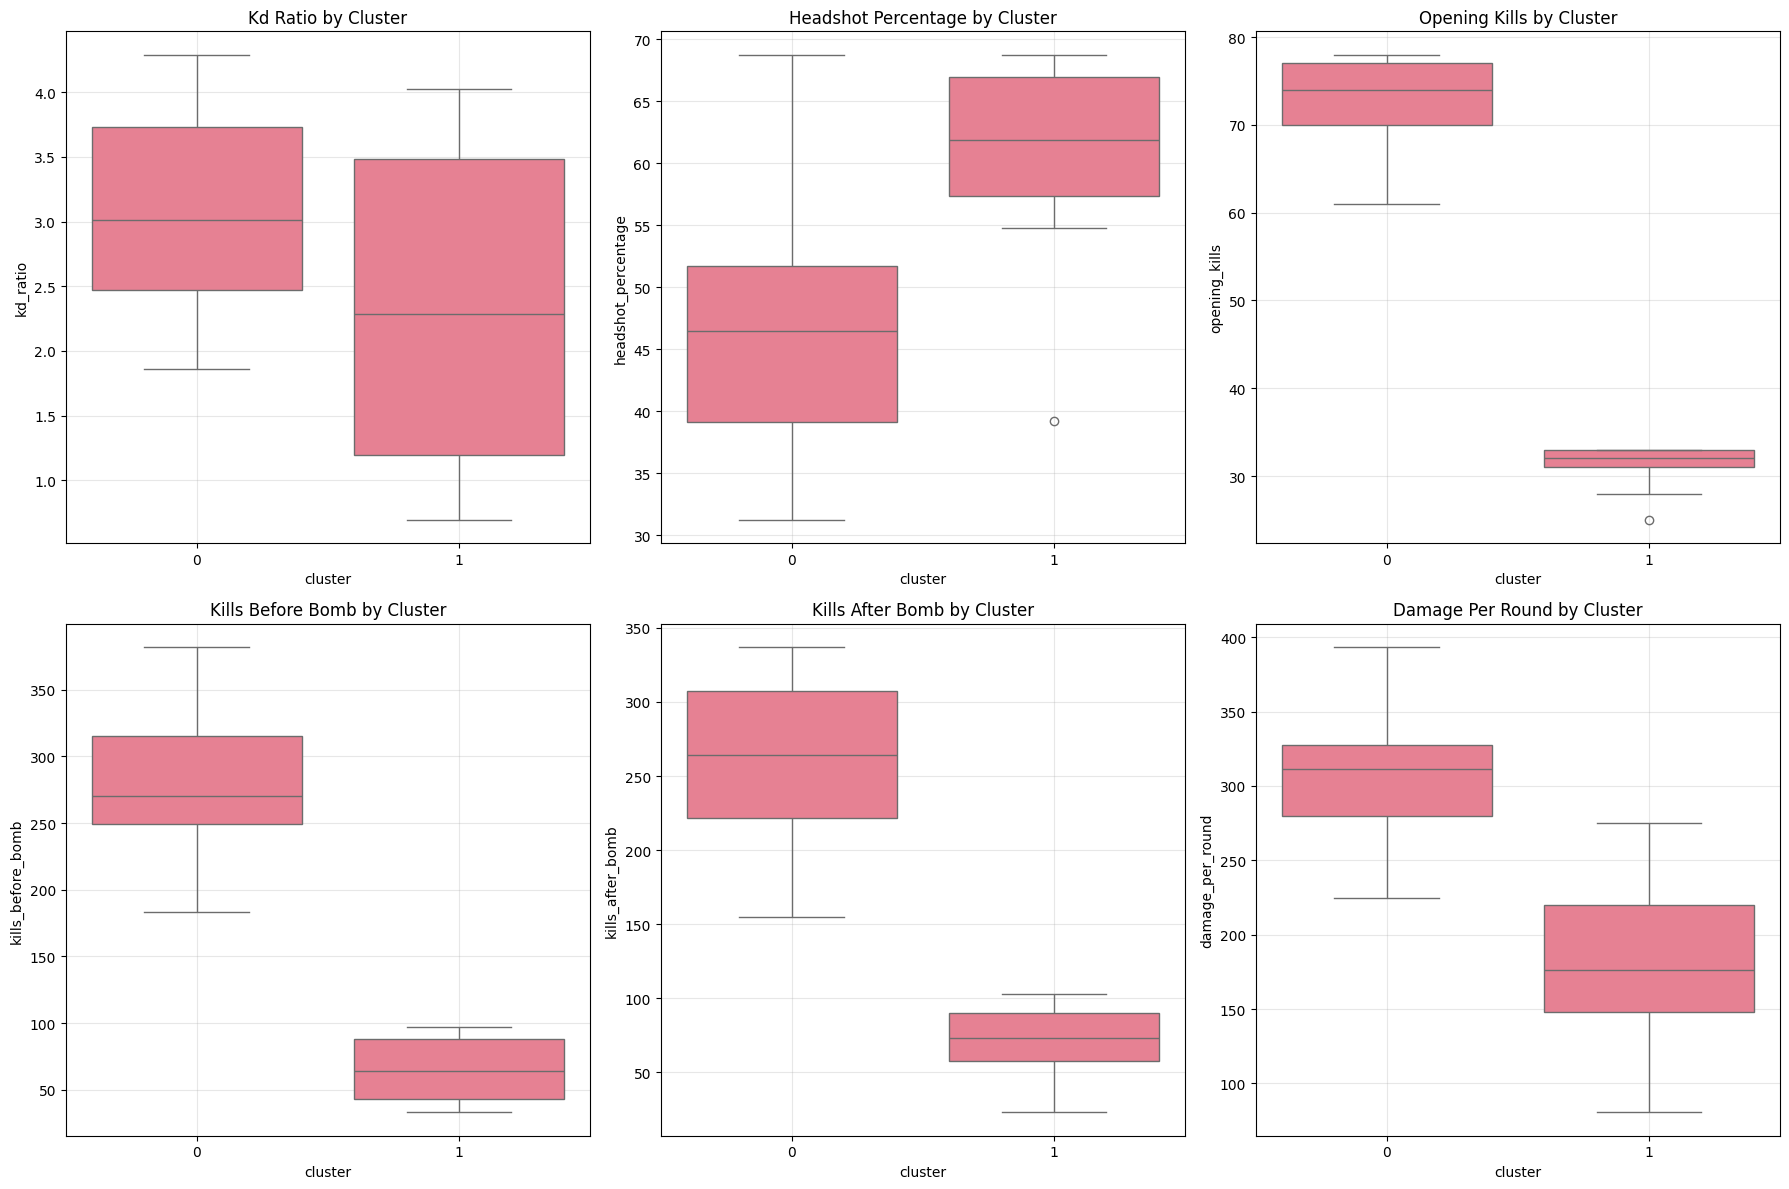

In [99]:
# Create box plots for key features by cluster
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

key_plot_features = ['kd_ratio', 'headshot_percentage', 'opening_kills', 
                    'kills_before_bomb', 'kills_after_bomb', 'damage_per_round']

for i, feature in enumerate(key_plot_features):
    if i < len(axes):
        sns.boxplot(data=df, x='cluster', y=feature, ax=axes[i])
        axes[i].set_title(f'{feature.replace("_", " ").title()} by Cluster')
        axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 7. Interpret Player Role Clusters


In [100]:
# Show example players from each cluster
print("\nEXAMPLE PLAYERS FROM EACH CLUSTER:")
print("=" * 50)

for cluster_num in range(optimal_k):
    cluster_players = df[df['cluster'] == cluster_num]
    
    # Show top 3 players by K/D ratio
    top_players = cluster_players.nlargest(3, 'kd_ratio')
    
    print(f"\nCLUSTER {cluster_num} - Top Players:")
    for _, player in top_players.iterrows():
        print(f"  {player['player_name']} (K/D: {player['kd_ratio']:.2f}, "
              f"HS%: {player['headshot_percentage']:.1f}%, "
              f"Opening: {player['opening_kills']})")



EXAMPLE PLAYERS FROM EACH CLUSTER:

CLUSTER 0 - Top Players:
  micro (K/D: 4.29, HS%: 44.7%, Opening: 77)
  Scorchyy (K/D: 4.24, HS%: 36.0%, Opening: 74)
  jsfeltner (K/D: 4.17, HS%: 39.1%, Opening: 74)

CLUSTER 1 - Top Players:
  shadiy (K/D: 4.03, HS%: 64.2%, Opening: 32)
  keen (K/D: 3.67, HS%: 39.2%, Opening: 33)
  SaVage (K/D: 3.50, HS%: 68.8%, Opening: 33)


## 8. Save Results


In [101]:
# Save the clustered data
output_file = 'player_role_clusters.csv'
df.to_csv(output_file, index=False)

# Save cluster centroids
centroids_file = 'cluster_centroids.csv'
cluster_centroids.to_csv(centroids_file)

print(f"Results saved to:")
print(f"  - {output_file} (players with cluster labels)")
print(f"  - {centroids_file} (cluster centroids)")

# Display final summary
print(f"\nFINAL SUMMARY:")
print(f"Total players analyzed: {len(df)}")
print(f"Optimal number of clusters: {optimal_k}")
print(f"Silhouette score: {silhouette_score(X_scaled, cluster_labels):.3f}")
print(f"\nCluster sizes:")
for cluster, count in cluster_counts.items():
    print(f"  Cluster {cluster}: {count} players ({count/len(df)*100:.1f}%)")


Results saved to:
  - player_role_clusters.csv (players with cluster labels)
  - cluster_centroids.csv (cluster centroids)

FINAL SUMMARY:
Total players analyzed: 30
Optimal number of clusters: 2
Silhouette score: 0.424

Cluster sizes:
  Cluster 0: 20 players (66.7%)
  Cluster 1: 10 players (33.3%)


## 9. Additional Analysis: Cluster Validation


Additional Cluster Quality Metrics:
Calinski-Harabasz Score: 26.48 (higher is better)
Davies-Bouldin Score: 0.91 (lower is better)
Silhouette Score: 0.424


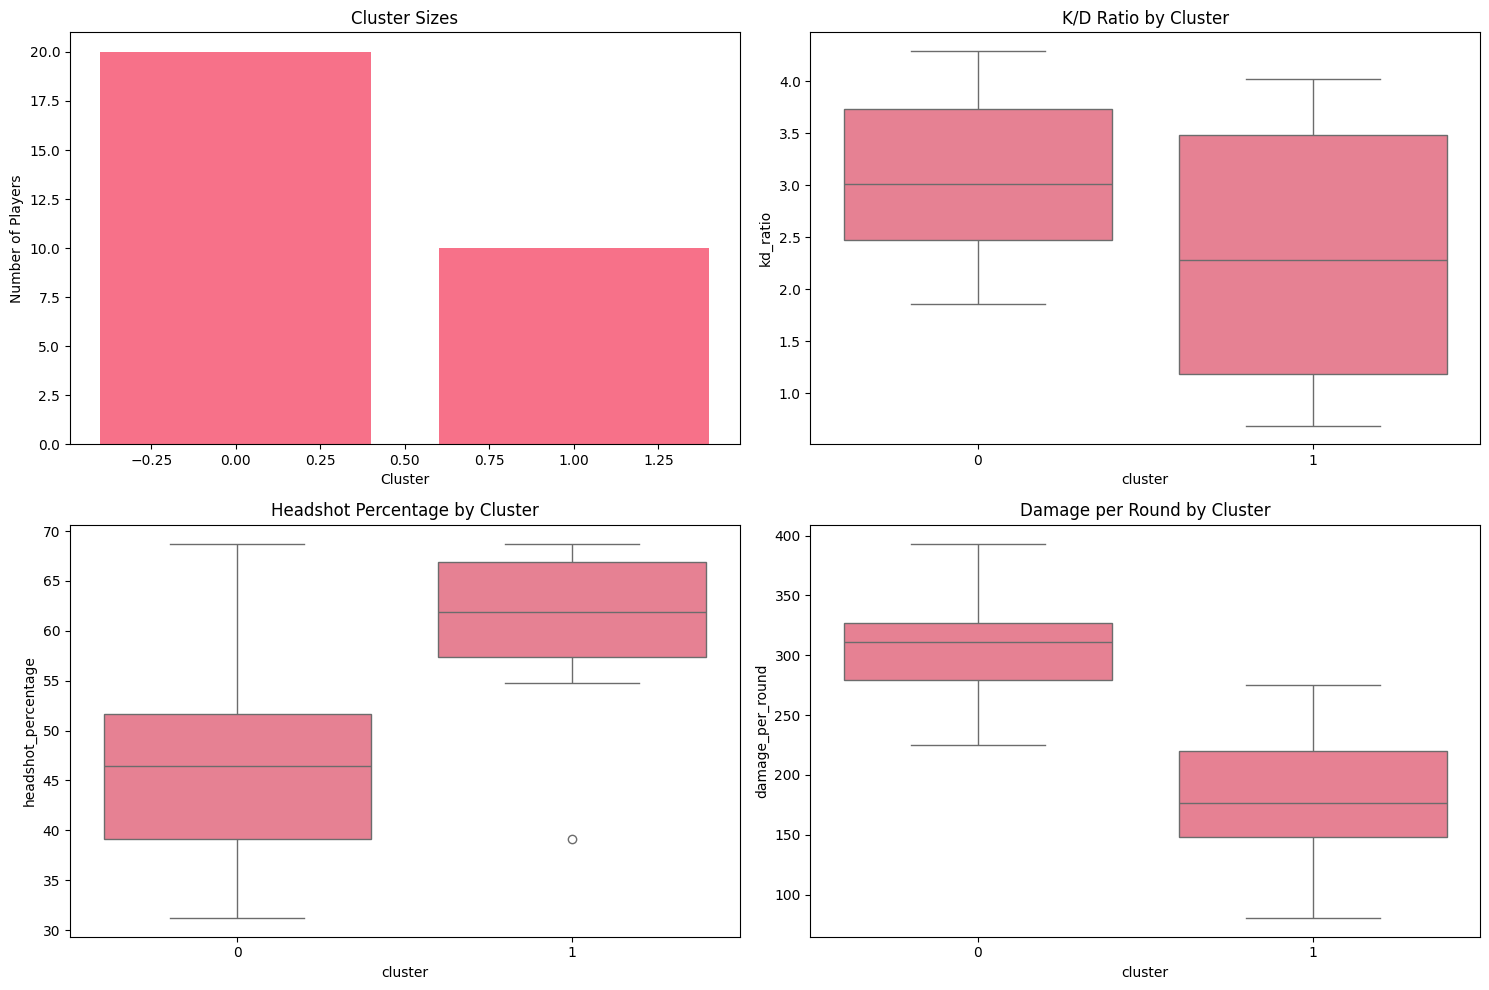

In [102]:
# Validate cluster quality with additional metrics
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

# Calculate additional cluster quality metrics
ch_score = calinski_harabasz_score(X_scaled, cluster_labels)
db_score = davies_bouldin_score(X_scaled, cluster_labels)

print("Additional Cluster Quality Metrics:")
print(f"Calinski-Harabasz Score: {ch_score:.2f} (higher is better)")
print(f"Davies-Bouldin Score: {db_score:.2f} (lower is better)")
print(f"Silhouette Score: {silhouette_score(X_scaled, cluster_labels):.3f}")

# Create a summary plot of cluster characteristics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Cluster sizes
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
axes[0, 0].bar(cluster_counts.index, cluster_counts.values)
axes[0, 0].set_title('Cluster Sizes')
axes[0, 0].set_xlabel('Cluster')
axes[0, 0].set_ylabel('Number of Players')

# K/D ratio distribution by cluster
sns.boxplot(data=df, x='cluster', y='kd_ratio', ax=axes[0, 1])
axes[0, 1].set_title('K/D Ratio by Cluster')

# Headshot percentage distribution by cluster
sns.boxplot(data=df, x='cluster', y='headshot_percentage', ax=axes[1, 0])
axes[1, 0].set_title('Headshot Percentage by Cluster')

# Damage per round distribution by cluster
sns.boxplot(data=df, x='cluster', y='damage_per_round', ax=axes[1, 1])
axes[1, 1].set_title('Damage per Round by Cluster')

plt.tight_layout()
plt.show()
